In [9]:
!pip install torch_geometric

In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def buildGraphSnaps(df, start_time, end_time, freq='6h'):
    #temporal graph snaps, each snap is the airport network graph at time t

    snapshots = []

    #clean up
    df = df.dropna(subset=['ORIGIN', 'DEST'])
    df['ORIGIN'] = df['ORIGIN'].astype(str)
    df['DEST'] = df['DEST'].astype(str)

    print(df[['DEP_DELAY', 'DISTANCE']].describe())

    for col in ['DEP_DELAY', 'DISTANCE', 'ARR_DELAY']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(0)

    #map to iata codes
    all_airports = set(df['ORIGIN']).union(set(df['DEST']))
    airport2global = {iata: i for i, iata in enumerate(sorted(all_airports))}
    num_airports = len(airport2global)

    #time binning
    df = df.copy()
    df['DEP_TIME'] = pd.to_datetime(df['DEP_TIME'], errors='coerce')
    df = df.dropna(subset=['DEP_TIME'])
    df['SNAPSHOT_TIME'] = df['DEP_TIME'].dt.floor(freq)
    grouped = dict(tuple(df.groupby('SNAPSHOT_TIME')))

    snapshot_times = sorted([t for t in grouped.keys() if start_time <= t <= end_time])

    for i in range(len(snapshot_times) - 1):
        t = snapshot_times[i]
        t_next = snapshot_times[i + 1]

        grp_t = grouped[t]
        grp_next = grouped[t_next]

        x = np.zeros((num_airports, 5), dtype=np.float32)
        y = np.zeros((num_airports, 1), dtype=np.float32)

        for iata in airport2global:
            idx = airport2global[iata]
            flights_from = grp_t[grp_t['ORIGIN'] == iata]
            flights_to   = grp_t[grp_t['DEST'] == iata]

            features = [
                len(flights_from),
                flights_from['DEP_DELAY'].mean(skipna=True) if not flights_from.empty else 0,
                len(flights_to),
                flights_to['ARR_DELAY'].mean(skipna=True) if not flights_to.empty else 0,
                flights_from['DISTANCE'].mean(skipna=True) if not flights_from.empty else 0,
            ]
            x[idx] = features

        #finding target at t+1
        for iata in airport2global:
            idx = airport2global[iata]
            flights_from_next = grp_next[grp_next['ORIGIN'] == iata]
            y[idx] = [
                flights_from_next['DEP_DELAY'].mean(skipna=True) if not flights_from_next.empty else 0
            ]

        
        edge_records = (
            grp_t.groupby(['ORIGIN', 'DEST'])
                .agg(flight_count=('DEP_DELAY', 'count'),
                     mean_distance=('DISTANCE', 'mean'))
                .reset_index()
        )

        edge_list, edge_weights = [], []
        for _, row in edge_records.iterrows():
            src_iata, dst_iata = row['ORIGIN'], row['DEST']
            if src_iata in airport2global and dst_iata in airport2global:
                src = airport2global[src_iata]
                dst = airport2global[dst_iata]
                edge_list.append((src, dst))
                weight = 0.4 * row['flight_count'] + 0.6 * row['mean_distance']
                edge_weights.append(weight)

        if edge_list:
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_weights, dtype=torch.float32).view(-1, 1)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_attr = torch.empty((0, 1), dtype=torch.float32)

        data = Data(
            x=torch.tensor(x, dtype=torch.float32),
            edge_index=edge_index,
            y=torch.tensor(y, dtype=torch.float32),
            snapshot_time=t,
            edge_attr=edge_attr
        )
        snapshots.append(data)

    snapshots = [s for s in snapshots if (s.x.sum(dim=1) != 0).sum() > 10]
    print(f"Built {len(snapshots)} paired snapshots (t → t+1) each with {num_airports} airports")

    return snapshots, airport2global



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import numpy as np

def visGraphActive(data, airport2global, title="Airports Graph"):
    """
    Visualize a PyG Data graph using matplotlib, with only active airports shown.
    Node color = average departure delay.
    """

    #active nodes
    active_mask = (data.x.sum(dim=1) != 0)
    active_nodes = torch.where(active_mask)[0].numpy()

    if len(active_nodes) == 0:
        print("no active airports in this snapshot.")
        return

    G = nx.DiGraph()
    edge_index = data.edge_index.numpy()
    G.add_nodes_from(range(data.num_nodes))
    G.add_edges_from(edge_index.T)
    G = G.subgraph(active_nodes)

    pos = nx.spring_layout(G, seed=0, k=1.5/np.sqrt(G.number_of_nodes()), iterations=200)

    delays = data.y.view(-1).numpy()
    delays_active = delays[active_nodes]

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title, fontsize=14)

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=delays_active,
        cmap='viridis',
        node_size=600,
        ax=ax
    )
    nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.8, alpha=0.3, ax=ax)

    idx2iata = {v: k for k, v in airport2global.items()}
    labels = {i: idx2iata[i] for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, ax=ax)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=delays_active.min(), vmax=delays_active.max()))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Avg DEP_DELAY (min)')

    ax.axis('off')
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-2082855430.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ORIGIN'] = df['ORIGIN'].astype(str)
/tmp/ipython-input-2082855430.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEST'] = df['DEST'].astype(str)


           DEP_DELAY       DISTANCE
count  502926.000000  524158.000000
mean       17.402699     811.305446
std        68.259678     589.965315
min       -56.000000      31.000000
25%        -5.000000     379.000000
50%        -1.000000     666.000000
75%        14.000000    1053.000000
max      3125.000000    5095.000000


/tmp/ipython-input-2082855430.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/tmp/ipython-input-2082855430.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(0)


✅ Built 142 paired snapshots (t → t+1), each with 351 airports
[351, 351, 351, 351, 351]
Data(x=[351, 5], edge_index=[2, 915], edge_attr=[915, 1], y=[351, 1], snapshot_time=2024-01-04 00:00:00)


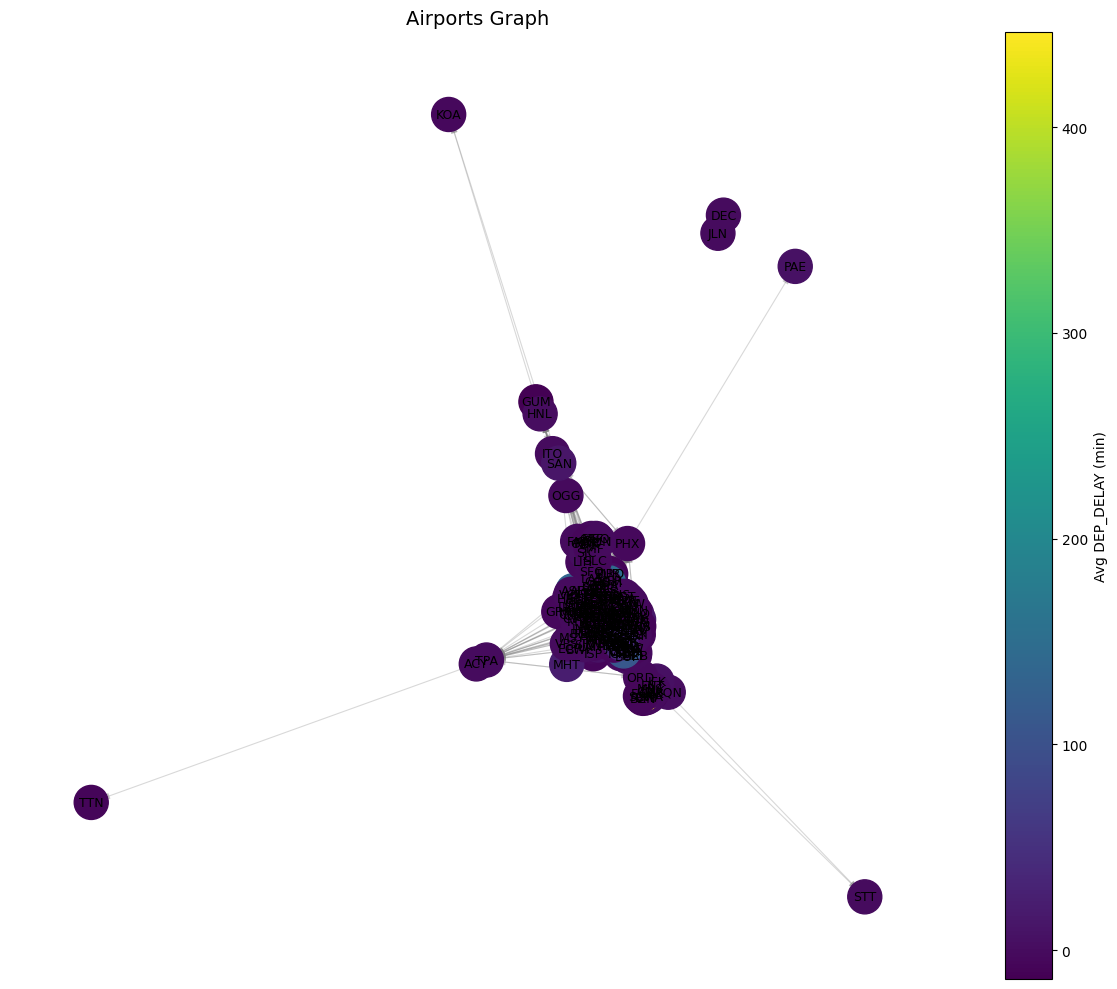

In [ ]:
df = pd.read_csv('/content/delay data.csv')

#clean crs_dep_time, convert to string, remove non-numeric characters, and fill missing with 0
df['CRS_DEP_TIME'] = (
    df['CRS_DEP_TIME']
    .astype(str)
    .str.replace(r'[^0-9]', '', regex=True)  # remove anything not a digit
    .replace('', '0')  # replace empty strings with '0'
    .astype(int)
)

#fixing fl_date
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='mixed', errors='coerce')
df['FL_DATE'] = df['FL_DATE'].dt.normalize()

df['DEP_HOUR'] = df['CRS_DEP_TIME'] // 100
df['DEP_MIN'] = df['CRS_DEP_TIME'] % 100
df['DEP_TIME'] = df['FL_DATE'] + pd.to_timedelta(df['DEP_HOUR'], unit='h') + pd.to_timedelta(df['DEP_MIN'], unit='m')
df = df.dropna(subset=['DEP_TIME'])
df['SNAPSHOT_TIME'] = df['DEP_TIME'].dt.floor('6h')



snapshots, airport2global = buildGraphSnaps(df, df['DEP_TIME'].min(), df['DEP_TIME'].max(), freq='6h')
print([snap.num_nodes for snap in snapshots[:5]])
print(snapshots[7])
visGraphActive(snapshots[7], airport2global)

In [13]:
snap = snapshots[50]
print("Number of nodes:", snap.num_nodes)
print("Number of edges:", snap.edge_index.shape[1])
print("Feature sample (first 5 airports):\n", snap.x[:5])
print("Target delay sample (first 5 airports):\n", snap.y[:5])


Number of nodes: 351
Number of edges: 2695
Feature sample (first 5 airports):
 tensor([[  1.0000,  58.0000,   5.0000,  -9.6000, 692.0000],
        [  0.0000,   0.0000,   1.0000,  96.0000,   0.0000],
        [ 10.0000,  17.3000,  19.0000,  20.6316, 798.3000],
        [  1.0000,   0.0000,   2.0000, -21.5000, 257.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])
Target delay sample (first 5 airports):
 tensor([[  1.3333],
        [111.0000],
        [  4.5385],
        [  0.0000],
        [233.0000]])


In [14]:
nonzero_nodes = (snap.x.sum(dim=1) > 0).sum()
print("Active airports in this snapshot:", nonzero_nodes.item())


Active airports in this snapshot: 284


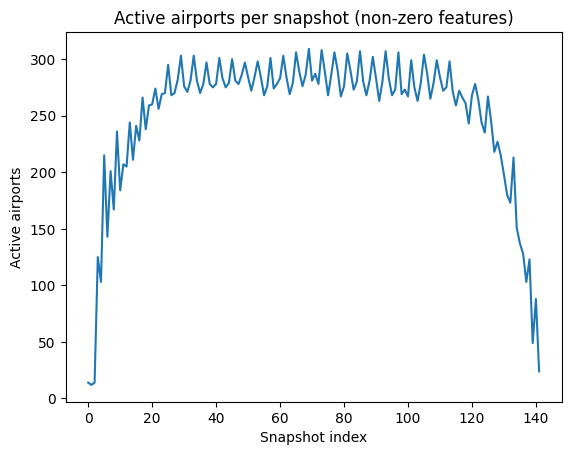

In [15]:
active_nodes_per_snap = [(s.x.sum(dim=1) > 0).sum().item() for s in snapshots]
plt.plot(active_nodes_per_snap)
plt.title("Active airports per snapshot (non-zero features)")
plt.xlabel("Snapshot index")
plt.ylabel("Active airports")
plt.show()



In [16]:
print(len(snapshots), type(snapshots[0]))
print(set([snap.num_nodes for snap in snapshots]))
print(set([snap.x.shape[1] for snap in snapshots]))

142 <class 'torch_geometric.data.data.Data'>
{351}
{5}


In [17]:
for i, snap in enumerate(snapshots):
    if torch.isnan(snap.x).any() or torch.isnan(snap.y).any():
        print(f"NaN in snapshot {i}")
    if torch.isinf(snap.x).any() or torch.isinf(snap.y).any():
        print(f"Inf in snapshot {i}")


In [18]:
for i, snap in enumerate(snapshots[:5]):
    print(f"\nSnapshot {i}")
    print("x NaNs per feature:", torch.isnan(snap.x).sum(dim=0))
    print("y NaNs:", torch.isnan(snap.y).sum())



Snapshot 0
x NaNs per feature: tensor([0, 0, 0, 0, 0])
y NaNs: tensor(0)

Snapshot 1
x NaNs per feature: tensor([0, 0, 0, 0, 0])
y NaNs: tensor(0)

Snapshot 2
x NaNs per feature: tensor([0, 0, 0, 0, 0])
y NaNs: tensor(0)

Snapshot 3
x NaNs per feature: tensor([0, 0, 0, 0, 0])
y NaNs: tensor(0)

Snapshot 4
x NaNs per feature: tensor([0, 0, 0, 0, 0])
y NaNs: tensor(0)


In [19]:
snap.x[torch.isnan(snap.x)] = 0
snap.y[torch.isnan(snap.y)] = 0


In [ ]:
from sklearn.preprocessing import StandardScaler
import torch

scaler_x = StandardScaler()
scaler_y = StandardScaler()
all_x = torch.cat([s.x for s in snapshots], dim=0)
all_y = torch.cat([s.y for s in snapshots], dim=0)

scaler_x.fit(all_x)
scaler_y.fit(all_y)


for s in snapshots:
    s.x = torch.tensor(scaler_x.transform(s.x), dtype=torch.float)
    s.y = torch.tensor(scaler_y.transform(s.y), dtype=torch.float)

In [21]:
import torch

torch.save({
    "snapshots": snapshots,
    "airport2global": airport2global
}, "flight_snapshots.pt")


In [22]:
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader

class SnapshotDataset(Dataset):
    def __init__(self, snapshots):
        self.snaps = snapshots

    def __len__(self):
        return len(self.snaps)

    def __getitem__(self, idx):
        return self.snaps[idx]

dataset = SnapshotDataset(snapshots)
loader = DataLoader(dataset, batch_size = 1, shuffle=False)

In [23]:
nan_mask = torch.isnan(snap.x)
nan_indices = torch.nonzero(nan_mask)
print(nan_indices)


tensor([], size=(0, 2), dtype=torch.int64)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GATDelayPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super().__init__()
        #first GAT layer with multi-head attention
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        #second GAT layer
        self.gat2 = GATConv(hidden_channels*heads, hidden_channels, heads=1, concat=True)
        #final MLP to map to output
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, x, edge_index, edge_attr=None):
        #gat default ignores edge_attr, to be fixed later with other graph neural net
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = self.mlp(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GATDelayPredictor(in_channels=5, hidden_channels=32, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

Epoch 001: Train RMSE=1.0385, Test RMSE=0.7982
Epoch 002: Train RMSE=1.0325, Test RMSE=0.7935
Epoch 003: Train RMSE=1.0312, Test RMSE=0.7935
Epoch 004: Train RMSE=1.0310, Test RMSE=0.7934
Epoch 005: Train RMSE=1.0306, Test RMSE=0.7929
Epoch 006: Train RMSE=1.0302, Test RMSE=0.7951
Epoch 007: Train RMSE=1.0308, Test RMSE=0.7954
Epoch 008: Train RMSE=1.0300, Test RMSE=0.7950
Epoch 009: Train RMSE=1.0297, Test RMSE=0.7912
Epoch 010: Train RMSE=1.0300, Test RMSE=0.7918
Epoch 011: Train RMSE=1.0296, Test RMSE=0.7966
Epoch 012: Train RMSE=1.0302, Test RMSE=0.7963
Epoch 013: Train RMSE=1.0292, Test RMSE=0.7936
Epoch 014: Train RMSE=1.0290, Test RMSE=0.7907
Epoch 015: Train RMSE=1.0297, Test RMSE=0.7927
Epoch 016: Train RMSE=1.0285, Test RMSE=0.7936
Epoch 017: Train RMSE=1.0289, Test RMSE=0.7917
Epoch 018: Train RMSE=1.0286, Test RMSE=0.7934
Epoch 019: Train RMSE=1.0283, Test RMSE=0.7926
Epoch 020: Train RMSE=1.0285, Test RMSE=0.7943
Epoch 021: Train RMSE=1.0287, Test RMSE=0.7909
Epoch 022: Tr

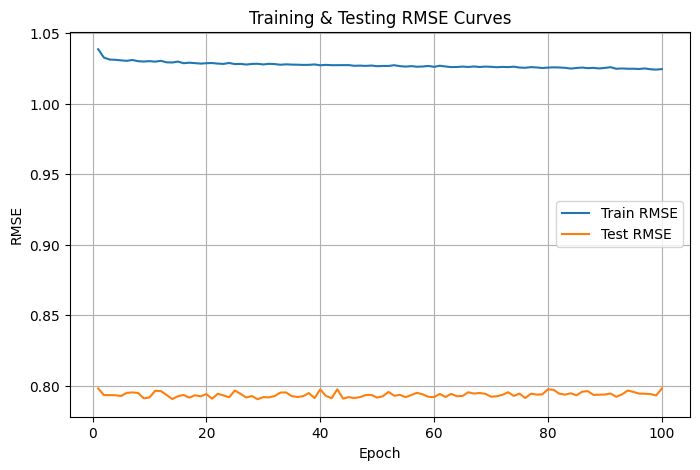

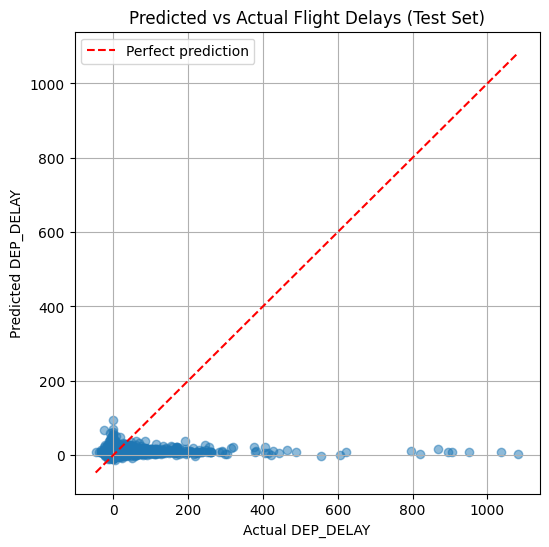

In [ ]:
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader

#splitting
num_snaps = len(snapshots)
train_snaps = snapshots[:int(0.8*num_snaps)]
test_snaps = snapshots[int(0.8*num_snaps):]

train_loader = DataLoader(SnapshotDataset(train_snaps), batch_size=1, shuffle=True)
test_loader = DataLoader(SnapshotDataset(test_snaps), batch_size=1, shuffle=False)

train_rmse_list = []
test_rmse_list = []

epochs = 100

for epoch in range(1, epochs+1):
    model.train()
    total_loss, total_nodes = 0.0, 0
    for snap in train_loader:
        x = snap.x.to(device)
        edge_index = snap.edge_index.to(device)
        y = snap.y.to(device)

        optimizer.zero_grad()
        pred = model(x, edge_index).squeeze()

        mask = (x.sum(dim=1) != 0)
        if mask.sum() == 0:
            continue

        loss = loss_fn(pred[mask], y[mask].squeeze())
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * mask.sum().item()
        total_nodes += mask.sum().item()

    train_rmse = (total_loss / total_nodes) ** 0.5
    train_rmse_list.append(train_rmse)

    model.eval()
    test_total, test_nodes = 0.0, 0
    with torch.no_grad():
        for snap in test_loader:
            x = snap.x.to(device)
            edge_index = snap.edge_index.to(device)
            y = snap.y.to(device)

            pred = model(x, edge_index).squeeze()
            mask = (x.sum(dim=1) != 0)
            if mask.sum() == 0:
                continue

            test_loss = loss_fn(pred[mask], y[mask].squeeze())
            test_total += test_loss.item() * mask.sum().item()
            test_nodes += mask.sum().item()

    test_rmse = (test_total / test_nodes) ** 0.5
    test_rmse_list.append(test_rmse)

    print(f"Epoch {epoch:03d}: Train RMSE={train_rmse:.4f}, Test RMSE={test_rmse:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_rmse_list, label="Train RMSE")
plt.plot(range(1, epochs+1), test_rmse_list, label="Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training & Testing RMSE Curves")
plt.legend()
plt.grid(True)
plt.show()

all_preds, all_targets = [], []
model.eval()
with torch.no_grad():
    for snap in test_loader:
        x = snap.x.to(device)
        edge_index = snap.edge_index.to(device)
        y = snap.y.to(device)

        pred = model(x, edge_index).squeeze()
        mask = (x.sum(dim=1) != 0)
        if mask.sum() == 0:
            continue

        all_preds.append(pred[mask].cpu().numpy())
        all_targets.append(y[mask].squeeze().cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)


all_preds_orig = scaler_y.inverse_transform(all_preds.reshape(-1,1)).flatten()
all_targets_orig = scaler_y.inverse_transform(all_targets.reshape(-1,1)).flatten()


plt.figure(figsize=(6,6))
plt.scatter(all_targets_orig, all_preds_orig, alpha=0.5)
plt.plot([all_targets_orig.min(), all_targets_orig.max()],
         [all_targets_orig.min(), all_targets_orig.max()],
         'r--', label='Perfect prediction')
plt.xlabel("Actual DEP_DELAY")
plt.ylabel("Predicted DEP_DELAY")
plt.title("Predicted vs Actual Flight Delays (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from torch.utils.data import Dataset

class SnapshotSequenceDataset(Dataset):
    def __init__(self, snapshots, seq_len=3):
        self.snapshots = snapshots
        self.seq_len = seq_len
        self.sequences = []
        self.targets = []

        for i in range(len(snapshots) - seq_len):
            seq_snaps = snapshots[i:i+seq_len]
            next_snap = snapshots[i+seq_len]  #target at t+1

            seq_x = [s.x for s in seq_snaps]
            seq_edge_index = [s.edge_index for s in seq_snaps]

            self.sequences.append((seq_x, seq_edge_index))
            self.targets.append(next_snap.y)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq_x, seq_edge_index = self.sequences[idx]
        y = self.targets[idx]
        return seq_x, seq_edge_index, y

In [ ]:
SEQ_LEN = 3
dataset = SnapshotSequenceDataset(snapshots, seq_len=SEQ_LEN)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)  #batch_size=1 because each item is a sequence of graphs

from torch.utils.data import random_split

def collate_fn(batch):
  return batch[0]

val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn = collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,collate_fn = collate_fn)

num_nodes = len(airport2global)

sequences = []
targets = []

for i in range(len(snapshots) - SEQ_LEN):
  seq_snaps = snapshots[i:i+SEQ_LEN]
  next_snap = snapshots[i+SEQ_LEN]

  seq_x = [s.x for s in seq_snaps]
  seq_edge_index = [s.edge_index for s in seq_snaps]

  sequences.append((seq_x,seq_edge_index))
  targets.append(next_snap.y)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class HotspotGATLSTM(nn.Module):
    def __init__(self, in_channels=5, gat_hidden=16, lstm_hidden=16, out_channels=1, heads=2, dropout=0.2):
        super().__init__()
        self.gat1 = GATConv(in_channels, gat_hidden, heads=heads, concat=True, dropout=dropout)
        self.gat2 = GATConv(gat_hidden*heads, gat_hidden, heads=1, concat=True, dropout=dropout)

        self.lstm_hidden = lstm_hidden
        self.lstm = nn.LSTM(input_size=gat_hidden, hidden_size=lstm_hidden, batch_first=True)

        self.mlp = nn.Sequential(
            nn.Linear(lstm_hidden, lstm_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, out_channels)
        )

    def forward(self, seq_x, seq_edge_index):
        #seq_x = list of [num_nodes, features], seq_edge_index = list of [2, num_edges]
        gat_outputs = []
        for x, edge_index in zip(seq_x, seq_edge_index):
            h = F.elu(self.gat1(x, edge_index))
            h = F.elu(self.gat2(h, edge_index))
            gat_outputs.append(h)

        #stack along time dimension: [num_nodes, seq_len, gat_hidden]
        h_seq = torch.stack(gat_outputs, dim=1)
        h_lstm, _ = self.lstm(h_seq)
       
        h_last = h_lstm[:, -1, :]
        out = self.mlp(h_last)
        return out


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HotspotGATLSTM(in_channels=5, gat_hidden=32, lstm_hidden=32, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

train_losses, val_losses = [], []
#epochs =100

for epoch in range(1, epochs+1):
    model.train()
    total_loss, total_nodes = 0.0, 0

    for seq_x, seq_edge_index, y in train_loader:
        seq_x = [x.squeeze(0).to(device) for x in seq_x]
        seq_edge_index = [ei.squeeze(0).to(device) for ei in seq_edge_index]
        y = y.squeeze(0).to(device)

        optimizer.zero_grad()
        pred = model(seq_x, seq_edge_index).squeeze()

        mask = (seq_x[-1].sum(dim=1) != 0)
        if mask.sum() == 0:
            continue


        loss = loss_fn(pred[mask], y[mask].squeeze())
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * mask.sum().item()
        total_nodes += mask.sum().item()

    train_rmse = (total_loss / total_nodes) ** 0.5
    train_losses.append(train_rmse)

    model.eval()
    val_total_loss, val_total_nodes = 0.0, 0

    with torch.no_grad():
        for seq_x, seq_edge_index, y in val_loader:
            seq_x = [x.squeeze(0).to(device) for x in seq_x]
            seq_edge_index = [ei.squeeze(0).to(device) for ei in seq_edge_index]
            y = y.squeeze(0).to(device)

            pred = model(seq_x, seq_edge_index).squeeze()
            mask = (seq_x[-1].sum(dim=1) != 0)
            if mask.sum() == 0:
                continue

            loss = loss_fn(pred[mask], y[mask].squeeze())
            val_total_loss += loss.item() * mask.sum().item()
            val_total_nodes += mask.sum().item()

    val_rmse = (val_total_loss / val_total_nodes) ** 0.5
    val_losses.append(val_rmse)

    print(f"Epoch {epoch:03d} | Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")




Epoch 001 | Train RMSE: 1.0050 | Val RMSE: 0.9882
Epoch 002 | Train RMSE: 0.9947 | Val RMSE: 0.9844
Epoch 003 | Train RMSE: 0.9926 | Val RMSE: 0.9844
Epoch 004 | Train RMSE: 0.9895 | Val RMSE: 0.9811
Epoch 005 | Train RMSE: 0.9890 | Val RMSE: 0.9801
Epoch 006 | Train RMSE: 0.9880 | Val RMSE: 0.9808
Epoch 007 | Train RMSE: 0.9871 | Val RMSE: 0.9794
Epoch 008 | Train RMSE: 0.9891 | Val RMSE: 0.9803
Epoch 009 | Train RMSE: 0.9857 | Val RMSE: 0.9805
Epoch 010 | Train RMSE: 0.9855 | Val RMSE: 0.9803
Epoch 011 | Train RMSE: 0.9855 | Val RMSE: 0.9780
Epoch 012 | Train RMSE: 0.9871 | Val RMSE: 0.9802
Epoch 013 | Train RMSE: 0.9849 | Val RMSE: 0.9781
Epoch 014 | Train RMSE: 0.9848 | Val RMSE: 0.9792
Epoch 015 | Train RMSE: 0.9846 | Val RMSE: 0.9781
Epoch 016 | Train RMSE: 0.9829 | Val RMSE: 0.9790
Epoch 017 | Train RMSE: 0.9814 | Val RMSE: 0.9785
Epoch 018 | Train RMSE: 0.9819 | Val RMSE: 0.9797
Epoch 019 | Train RMSE: 0.9851 | Val RMSE: 0.9776
Epoch 020 | Train RMSE: 0.9824 | Val RMSE: 0.9797


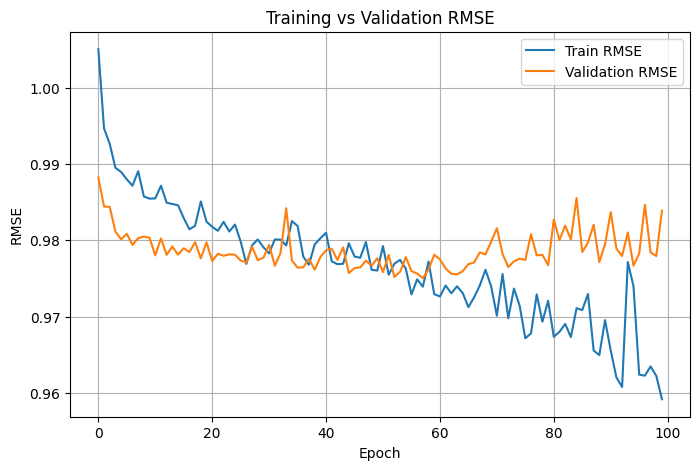

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train RMSE")
plt.plot(val_losses, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.patches as patches


# REGION_SIZE = 10          
# REGION_THRESHOLD = 15    
# SEQ_LEN = 6               

num_airports = snapshots[0].x.shape[0]
regions = [list(range(i, min(i + REGION_SIZE, num_airports)))
           for i in range(0, num_airports, REGION_SIZE)]

frames = []
model.eval() 
with torch.no_grad():
    #iterate through snapshots starting from SEQ_LEN to create sequences for prediction
    for t in range(SEQ_LEN, len(snapshots)):
        seq_x = [snapshots[i].x.to(device) for i in range(t - SEQ_LEN, t)]
        seq_edge_index = [snapshots[i].edge_index.to(device) for i in range(t - SEQ_LEN, t)]

        pred = model(seq_x, seq_edge_index).squeeze().cpu().numpy()
        frames.append(pred)


last_snapshot = snapshots[-1]
mask_active = (last_snapshot.x.sum(dim=1) != 0).cpu().numpy()
active_nodes_indices = np.where(mask_active)[0]

G_active = nx.DiGraph()
edge_index_last = last_snapshot.edge_index.cpu().numpy()
active_edges = [(u, v) for u, v in edge_index_last.T if u in active_nodes_indices and v in active_nodes_indices]
G_active.add_edges_from(active_edges)


pos = nx.spring_layout(G_active, seed=42)

frames_active_preds = [frame[mask_active] for frame in frames]

frames_active_orig_preds = [scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten() for preds in frames_active_preds]

if frames_active_orig_preds: 
    all_vals = np.concatenate(frames_active_orig_preds)
   
    vmin = np.min(all_vals)
    vmax = np.max(all_vals)
    if vmin == vmax:
        norm = plt.Normalize(vmin=vmin - 1, vmax=vmax + 1) 
    else:
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

    cmap = cm.get_cmap('Reds') 
else:
    print("No frames to animate.")
    
exit() #comment this line to stop execution

fig, ax = plt.subplots(figsize=(12, 10))

def update(frame_idx):
    ax.clear()

    pred_delay_active = frames_active_orig_preds[frame_idx]

    colors = [cmap(norm(v)) for v in pred_delay_active]

    nx.draw_networkx_nodes(G_active, pos, node_color=colors, node_size=600, ax=ax)
    nx.draw_networkx_edges(G_active, pos, edge_color="gray", width=0.8, alpha=0.3, ax=ax)

    idx2iata = {v: k for k, v in airport2global.items()}
    active_node_labels = {node: idx2iata[node] for node in G_active.nodes()}
    nx.draw_networkx_labels(G_active, pos, labels=active_node_labels, font_size=9, ax=ax)

    
    for region in regions:
        #only keep airports that exist in the current active subgraph
        region_nodes = [n for n in region if n in G_active.nodes()]
        if not region_nodes:
            continue

        #calculate average predicted delay for the region's active nodes in this frame
        region_avg = np.mean([pred_delay_active[list(G_active.nodes()).index(n)] for n in region_nodes])

        if region_avg >= REGION_THRESHOLD:
            #find the positions of the nodes in the region
            region_pos = np.array([pos[n] for n in region_nodes])
            #calculate bounding box or a representative center and size
            x_min, y_min = np.min(region_pos, axis=0)
            x_max, y_max = np.max(region_pos, axis=0)

            width = x_max - x_min + 0.1
            height = y_max - y_min + 0.1
            center_x = x_min + width / 2
            center_y = y_min + height / 2

            rect = patches.Rectangle((x_min - 0.05, y_min - 0.05), width, height,
                                     linewidth=1, edgecolor='orange', facecolor='orange', alpha=0.3, zorder=-1)
            ax.add_patch(rect)


    ax.set_title(f"Predicted Delays — Snapshot {frame_idx + SEQ_LEN}") 
    ax.axis("off")

    if frames_active_orig_preds:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, label='Predicted DEP_DELAY (min)')


    return ax.artists + ax.collections 


if frames_active_orig_preds:
    
    anim = FuncAnimation(fig, update, frames=len(frames_active_orig_preds), interval=600, repeat=False)

    # Save to GIF
    writer = PillowWriter(fps=2) # Frames per second
    anim.save("hotspot_evolution.gif", writer=writer)
    plt.close(fig) 

    print("Animation saved as hotspot_evolution.gif")
else:
    print("Animation skipped as there were no frames to animate.")

/tmp/ipython-input-4115399776.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


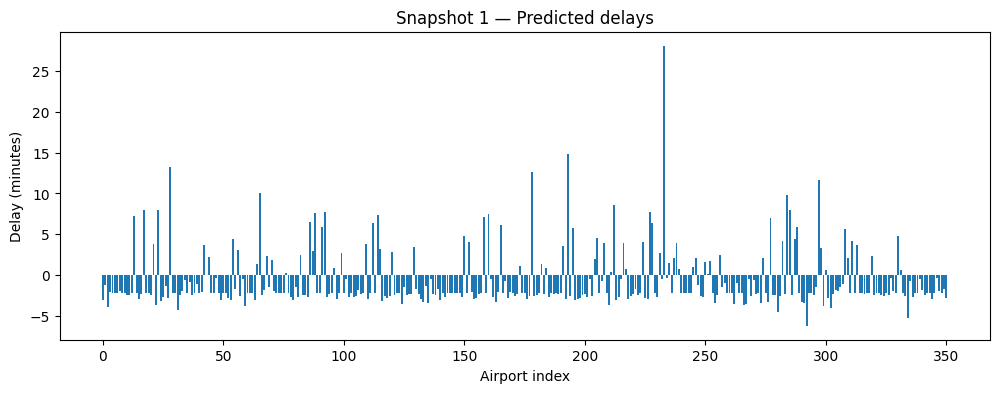

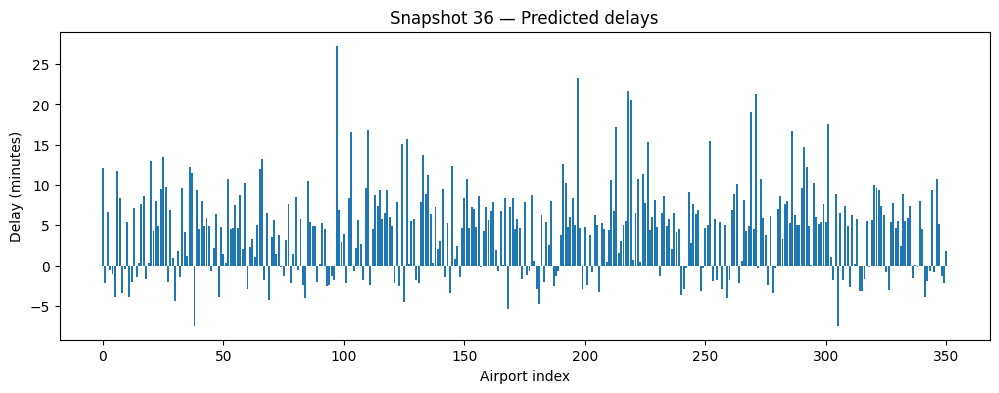

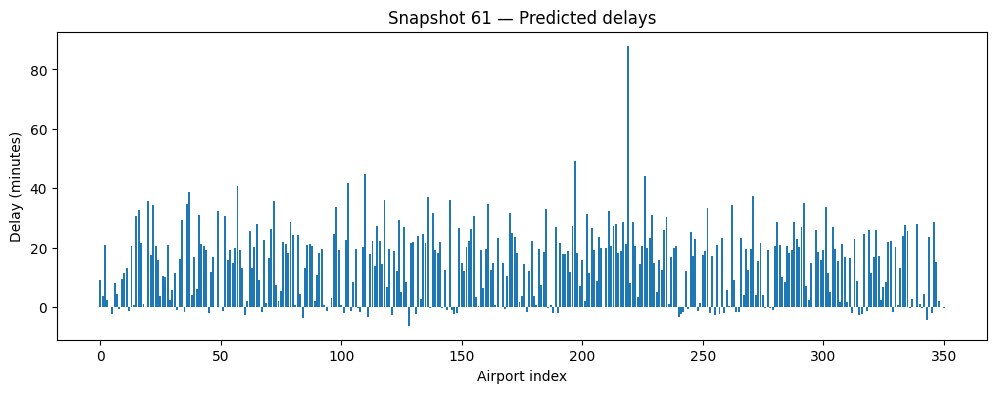

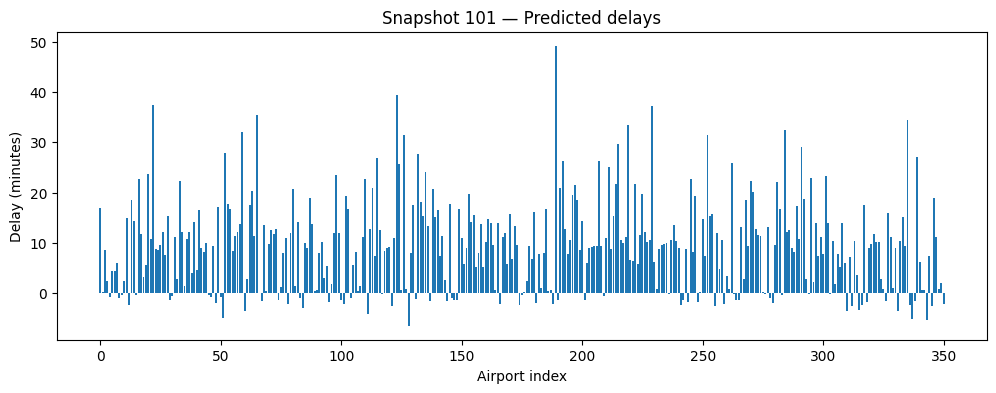

In [50]:
for t in [0, 35, 60, 100]:
    seq_x = [snapshots[i].x.to(device) for i in range(t-SEQ_LEN, t)]
    seq_edge_index = [snapshots[i].edge_index.to(device) for i in range(t-SEQ_LEN, t)]
    pred = model(seq_x, seq_edge_index).squeeze().detach().cpu().numpy()
    pred_delay = scaler_y.inverse_transform(pred.reshape(-1,1)).flatten()

    plt.figure(figsize=(12,4))
    plt.bar(range(len(pred_delay)), pred_delay)
    plt.title(f"Snapshot {t+1} — Predicted delays")
    plt.ylabel("Delay (minutes)")
    plt.xlabel("Airport index")
    plt.show()


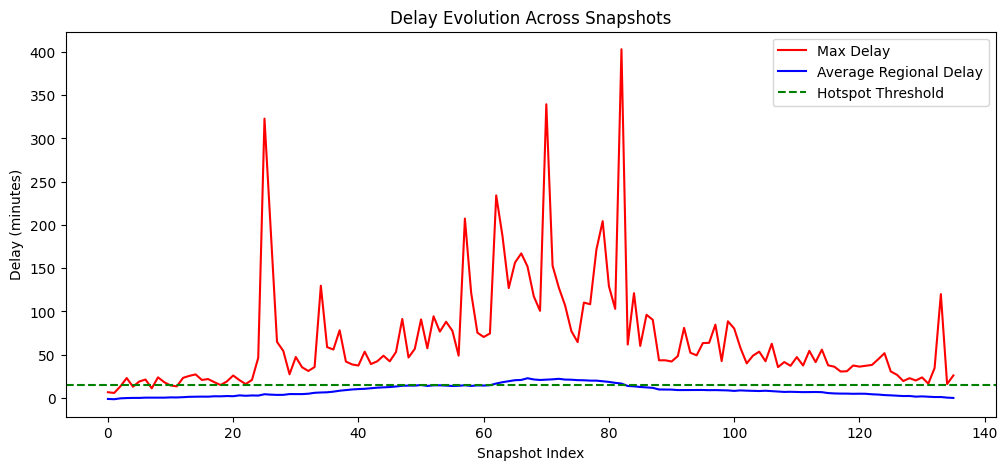

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


regions = [list(range(i, min(i + REGION_SIZE, num_airports)))
           for i in range(0, num_airports, REGION_SIZE)]

max_delays = []
avg_region_delays = []

for pred_delay in frames:
    max_delays.append(pred_delay.max())

   
    region_sums = [pred_delay[region].mean() for region in regions]
    avg_region_delays.append(np.mean(region_sums))


plt.figure(figsize=(12,5))
plt.plot(max_delays, label='Max Delay', color='red')
plt.plot(avg_region_delays, label='Average Regional Delay', color='blue')
plt.axhline(HOTSPOT_THRESHOLD, color='green', linestyle='--', label='Hotspot Threshold')
plt.xlabel("Snapshot Index")
plt.ylabel("Delay (minutes)")
plt.title("Delay Evolution Across Snapshots")
plt.legend()
plt.show()


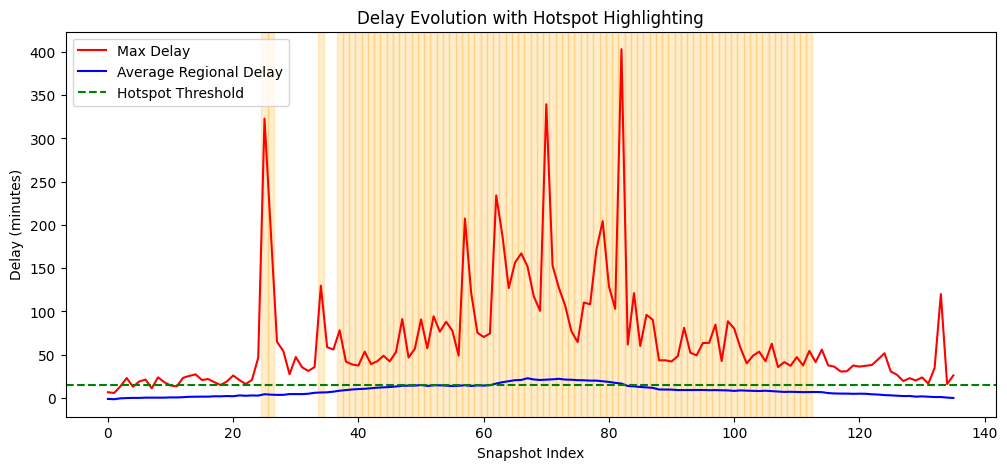

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#frames: list of predicted delays per snapshot
#regions: list of lists of airport indices defining each region
#HOTSPOT_THRESHOLD: threshold for region to be considered a hotspot

hotspot_snapshots = []

max_delays = []
avg_region_delays = []

for i, pred_delay in enumerate(frames):
    max_delays.append(pred_delay.max())

    region_avgs = [pred_delay[region].mean() for region in regions]
    avg_region_delays.append(np.mean(region_avgs))

    # Mark snapshot as hotspot if any region exceeds threshold
    if any(region_avg >= HOTSPOT_THRESHOLD for region_avg in region_avgs):
        hotspot_snapshots.append(i)

plt.figure(figsize=(12,5))
plt.plot(max_delays, label='Max Delay', color='red')
plt.plot(avg_region_delays, label='Average Regional Delay', color='blue')
plt.axhline(HOTSPOT_THRESHOLD, color='green', linestyle='--', label='Hotspot Threshold')

for snap in hotspot_snapshots:
    plt.axvspan(snap-0.5, snap+0.5, color='orange', alpha=0.2)

plt.xlabel("Snapshot Index")
plt.ylabel("Delay (minutes)")
plt.title("Delay Evolution with Hotspot Highlighting")
plt.legend()
plt.show()
